https://www.kaggle.com/code/yasserhessein/alzheimer-s-classification-nasnetlarge

# Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Importing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DIR_MAIN = '/content/drive/MyDrive/CCPS Summer Internship/SplitDataset/'
DIR_MAIN = '/content/drive/MyDrive/CCPS/DataSetSplit/SplitDataset/'

TEST_DIR = DIR_MAIN + 'test'
TRAIN_DIR = DIR_MAIN + 'train'
VAL_DIR = DIR_MAIN + 'val'

In [ ]:
IMG_SHAPE  = 224
batch_size = 32

# Data Generators

In [ ]:
image_gen_train = ImageDataGenerator(rescale = 1./255)

train_data_gen = image_gen_train.flow_from_directory(
    batch_size = batch_size,
    directory = TRAIN_DIR,
    shuffle= True,
    target_size = (IMG_SHAPE,IMG_SHAPE),
    class_mode = 'categorical')


image_generator_validation = ImageDataGenerator(rescale=1./255)

val_data_gen = image_generator_validation.flow_from_directory(
    batch_size=batch_size,
    directory=VAL_DIR,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='categorical')

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(
    batch_size=batch_size,
    directory=TEST_DIR,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='categorical')

Found 2677 images belonging to 4 classes.
Found 764 images belonging to 4 classes.
Found 385 images belonging to 4 classes.


In [ ]:
dataset_labels = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Benign' 'Early' 'Pre' 'Pro']


# NASNetLarge Model

In [ ]:
base_model = tf.keras.applications.NASNetLarge(input_shape=(224,224,3),include_top=False,weights="imagenet")

343610240/343610240 [==============================] - 2s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers[:-3]:
    layer.trainable=False

In [ ]:
# Building model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 dropout (Dropout)           (None, 7, 7, 4032)        0         
                                                                 
 flatten (Flatten)           (None, 197568)            0         
                                                                 
 batch_normalization (BatchN  (None, 197568)           790272    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4)                 790276    
                                                                 
 batch_normalization_1 (Batc  (None, 4)                16        
 hNormalization)                                        

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_data_gen.samples/train_data_gen.batch_size)
val_steps_per_epoch = np.ceil(val_data_gen.samples/val_data_gen.batch_size)
hist = model.fit(
train_data_gen,
epochs=20,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=val_data_gen,
validation_steps=val_steps_per_epoch).history

Epoch 1/20
84/84 [==============================] - 757s 9s/step - loss: 1.3252 - acc: 0.3579 - val_loss: 1.2005 - val_acc: 0.5327
Epoch 2/20
84/84 [==============================] - 46s 552ms/step - loss: 1.2550 - acc: 0.4061 - val_loss: 1.1914 - val_acc: 0.4738
Epoch 3/20
84/84 [==============================] - 46s 543ms/step - loss: 1.2253 - acc: 0.4244 - val_loss: 1.1649 - val_acc: 0.4686
Epoch 4/20
84/84 [==============================] - 47s 562ms/step - loss: 1.1934 - acc: 0.4400 - val_loss: 1.1366 - val_acc: 0.4817
Epoch 5/20
84/84 [==============================] - 45s 540ms/step - loss: 1.1797 - acc: 0.4445 - val_loss: 1.0926 - val_acc: 0.4908
Epoch 6/20
84/84 [==============================] - 46s 549ms/step - loss: 1.1490 - acc: 0.4569 - val_loss: 1.0636 - val_acc: 0.5183
Epoch 7/20
84/84 [==============================] - 47s 561ms/step - loss: 1.1357 - acc: 0.4602 - val_loss: 1.0276 - val_acc: 0.5471
Epoch 8/20
84/84 [==============================] - 45s 539ms/step - lo

# Exporting Model

In [ ]:
# Saving the model
ALL_SAVED_MODEL_PATH = '/content/gdrive/MyDrive/CCPS Summer Internship/NewModels/NasNetLarge.h5'
model.save(ALL_SAVED_MODEL_PATH)

In [ ]:
test_image_batch, test_label_batch = next(iter(test_data_gen))
true_label_ids = np.argmax(test_label_batch, axis=-1)
print("Test batch shape:", test_image_batch.shape)

Test batch shape: (32, 224, 224, 3)


In [ ]:
results = model.evaluate(test_image_batch, test_label_batch)

1/1 [==============================] - 0s 463ms/step - loss: 0.9250 - acc: 0.8750


In [ ]:
results

[0.9250054955482483, 0.875]

# Testing Model

In [ ]:
import pandas as pd

In [ ]:
tf_model_predictions = model.predict(test_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results of NasNetLarge for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 6s 6s/step
Prediction results of NasNetLarge for the first elements


,Benign,Early,Pre,Pro
0,0.323294,0.172302,0.266836,0.237568
1,0.234578,0.125989,0.450397,0.189036
2,0.177875,0.528910,0.087308,0.205907
3,0.323433,0.172425,0.266647,0.237495
4,0.239886,0.251864,0.176885,0.331365


In [ ]:
import matplotlib.pyplot as plt

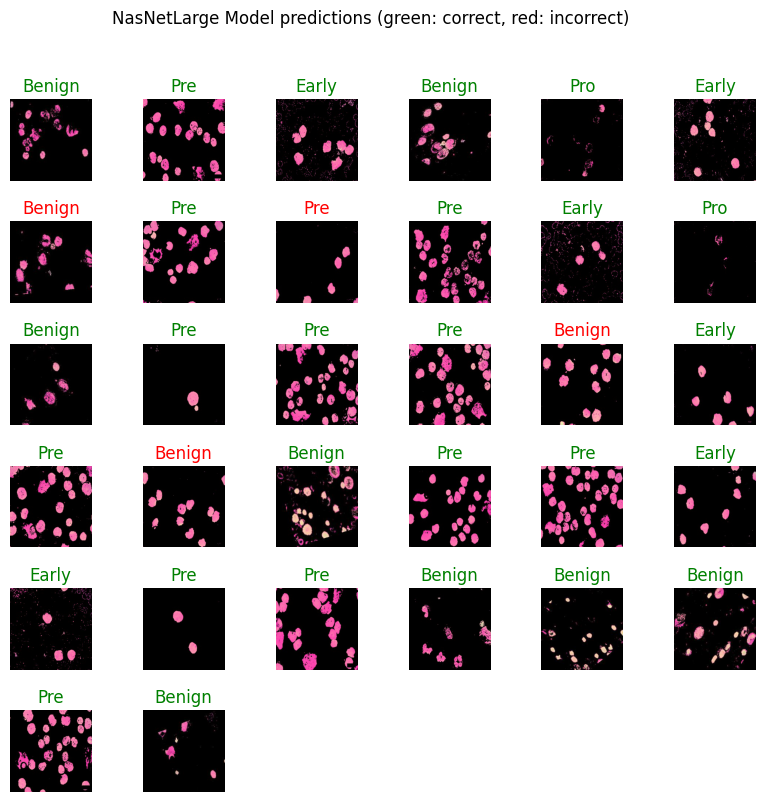

In [ ]:
predicted_ids_NasNet = np.argmax(tf_model_predictions, axis=-1)
predicted_labels_NasNet = dataset_labels[predicted_ids_NasNet]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_ids_NasNet[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels_NasNet[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("NasNetLarge Model predictions (green: correct, red: incorrect)")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
claRep = classification_report(true_label_ids, predicted_ids_NasNet)
claRep

'              precision    recall  f1-score   support\n\n           0       0.73      1.00      0.84         8\n           1       1.00      0.67      0.80         9\n           2       0.92      1.00      0.96        12\n           3       1.00      0.67      0.80         3\n\n    accuracy                           0.88        32\n   macro avg       0.91      0.83      0.85        32\nweighted avg       0.90      0.88      0.87        32\n'

In [ ]:
cm = confusion_matrix(true_label_ids, predicted_ids_NasNet)
accuracy = accuracy_score(true_label_ids, predicted_ids_NasNet)
precision = precision_score(true_label_ids, predicted_ids_NasNet, average='macro')
recall = recall_score(true_label_ids, predicted_ids_NasNet, average='macro')
f1 = f1_score(true_label_ids, predicted_ids_NasNet, average='macro')

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[ 8  0  0  0]
 [ 2  6  1  0]
 [ 0  0 12  0]
 [ 1  0  0  2]]
Accuracy: 0.875
Precision: 0.9125874125874126
Recall: 0.8333333333333333
F1 Score: 0.8505263157894738
